<a href="https://colab.research.google.com/github/JacobJS56/Dissertation/blob/main/Dissertation_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Detecting Anomalies in Microservices**

Import packages needed for the project

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn import metrics
import scipy.stats as stats
import pylab
from time import process_time

# Data Exploration on Dataset

## Explaning the Dataset

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/JacobJS56/Dissertation/main/Datasets/labelled_dataset.csv")
#np.random.shuffle(df.values)
df.head()

,Microservices,CPU,mem,response,throughput,timestamp,label
0,bookshop-books,34.6,4297,6.485,22.000,07/07/2020 17:19,normal
1,bookshop-purchases,36.0,585,8.686,9.367,07/07/2020 17:19,normal
2,bookshop-ui,36.8,291,5.561,9.467,07/07/2020 17:19,normal
3,bookshop-ui,36.2,291,13.550,9.267,07/07/2020 17:19,normal
4,bookshop-books,36.2,4298,2.877,16.710,07/07/2020 17:20,normal


**Dataset Overview**

---



**Microservices:** Microservice the data is being monitored from

**CPU:** CPU usage

**mem:** memory usage

**response:** time it takes from when the system receives a request to generating a response

**throughput:** the rate of data or messages transferred in a fixed time interval

**timestamp:** time in which a metric was captured

**Features by Variance**

In [ ]:
# Response has the highest variance
df.var()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


CPU           4.554862e+02
mem           3.330020e+06
response      7.805978e+06
throughput    4.520254e+03
dtype: float64

**Features by Correlation**

In [ ]:
sns.pairplot(df, hue="Microservices", diag_kind="hist")

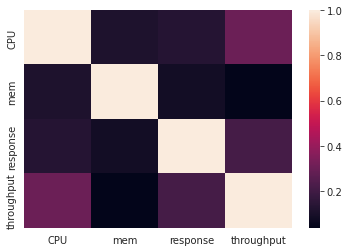

In [ ]:
# little correlation when looking at the system as a whole
sns.heatmap(abs(df.corr()))

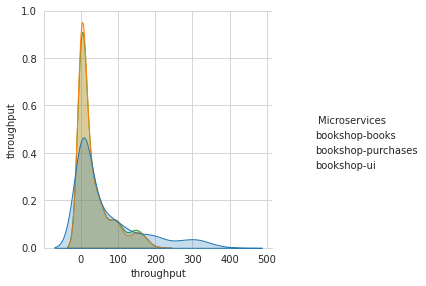

In [ ]:
# we can see each system has different datapoints and correlations
sns.pairplot(df, hue="Microservices", kind="reg", x_vars=['throughput',], y_vars=['throughput'], height=4)

## Power Transformation

Used to attempt to normalise a feature using Box-Cox below

Response

In [ ]:
# positive skew
plt.hist(df['response'], bins=8)

In [ ]:
stats.probplot(df['response'],plot=pylab)

In [ ]:
df['response'], parameters = stats.boxcox(df['response'])
plt.hist(df['response'], bins=25)

In [ ]:
stats.probplot(df['response'],plot=pylab)

Throughput

In [ ]:
# positive skew
plt.hist(df['throughput'], bins=8)

In [ ]:
stats.probplot(df['throughput'],plot=pylab);

In [ ]:
df['throughput'], parameters = stats.boxcox(df['throughput'])
plt.hist(df['throughput'], bins=25)

In [ ]:
stats.probplot(df['throughput'],plot=pylab);

CPU

In [ ]:
# positive skew
plt.hist(df['CPU'], bins=15)

In [ ]:
stats.probplot(df['CPU'],plot=pylab)

In [ ]:
#df['CPU'], parameters = stats.boxcox(df['CPU'])
d = np.cbrt(df['CPU'])
plt.hist(d, bins=50)

In [ ]:
stats.probplot(d,plot=pylab)

Memory

In [ ]:
# positive skew
plt.hist(df['mem'], bins=8)

In [ ]:
stats.probplot(df['mem'],plot=pylab)

In [ ]:
d, parameters = stats.boxcox(df['mem'])
plt.hist(d, bins=50)

In [ ]:
stats.probplot(d,plot=pylab);

Indidvual Services

In [ ]:
# isolating books
dfBooks = df[df.Microservices.isin(['bookshop-books'])]

# Memory and Throughput has the highest variance
dfBooks.var()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


CPU                2.105316
mem           813235.227090
response           3.369277
throughput         8.225300
dtype: float64

In [ ]:
# more correlation mainly linked to throughput
dfUI = df[df.Microservices.isin(['bookshop-ui'])]
dfUI.var()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


CPU             2.141731
mem           290.206220
response        1.852334
throughput      7.732951
dtype: float64

In [ ]:
# more correlation mainly linked to throughput
dfPurchases = df[df.Microservices.isin(['bookshop-purchases'])]
dfPurchases.var()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


CPU           2.112592e+00
mem           2.594638e+06
response      4.586203e-01
throughput    6.928732e+00
dtype: float64

Labels Distribution


In [ ]:
print(df['label'].value_counts())

normal         1939
ui_a            361
books_a         350
purchases_a      76
Name: label, dtype: int64


Can see purchases has a lot less

# Machine Learning Models

## Sklearn models

Replacing categorical data column with one hot encoding for training models

In [ ]:
df = pd.get_dummies(df, columns=["Microservices"])
df.head(7)

,CPU,mem,response,throughput,timestamp,label,Microservices_bookshop-books,Microservices_bookshop-purchases,Microservices_bookshop-ui
0,6.597463,4297,1.587155,3.629971,07/07/2020 17:19,normal,1,0,0
1,6.721837,585,1.790397,2.511115,07/07/2020 17:19,normal,0,1,0
2,6.791438,291,1.475872,2.524444,07/07/2020 17:19,normal,0,0,1
3,6.739335,291,2.079848,2.497658,07/07/2020 17:19,normal,0,0,1
4,6.739335,4298,0.962222,3.258951,07/07/2020 17:20,normal,1,0,0
5,6.497320,585,2.088996,2.213447,07/07/2020 17:20,normal,0,1,0
6,6.506516,291,2.198636,2.173992,07/07/2020 17:20,normal,0,0,1


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
df['timestamp'] = oe.fit_transform(df['timestamp'].values.reshape(-1,1))
df.head(7)

,CPU,mem,response,throughput,timestamp,label,Microservices_bookshop-books,Microservices_bookshop-purchases,Microservices_bookshop-ui
0,6.597463,4297,1.587155,3.629971,0.0,normal,1,0,0
1,6.721837,585,1.790397,2.511115,0.0,normal,0,1,0
2,6.791438,291,1.475872,2.524444,0.0,normal,0,0,1
3,6.739335,291,2.079848,2.497658,0.0,normal,0,0,1
4,6.739335,4298,0.962222,3.258951,1.0,normal,1,0,0
5,6.497320,585,2.088996,2.213447,1.0,normal,0,1,0
6,6.506516,291,2.198636,2.173992,1.0,normal,0,0,1


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# X is features
# y is labels
X = df[['CPU',	'mem', 'response',	'throughput', 'timestamp', 'Microservices_bookshop-books', 'Microservices_bookshop-purchases', 'Microservices_bookshop-ui']]
y = df['label']

scoresDf = pd.DataFrame()

# number of subsets
k = 3

tscv = TimeSeriesSplit(max_train_size=None, n_splits=2)

Evaluation Helper function

In [ ]:
def saveScore(scoresDf, model_name, accuracy_score, precision_score, recall_score, f1_score, t1):
  scoresDf = scoresDf.append({
    'model_name' : model_name,
    'accuracy': accuracy_score,
    'precision' : precision_score,
    'recall' : recall_score,
    'f1_score' : f1_score,
    't1' : t1,
  }, ignore_index=True)
  return scoresDf

**Random Forest**


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# score arrays
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
t1 = []

for train_index, test_index in tscv.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # create classifier, fit data and predict on test data
  t1_start = process_time()
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  pred = rfc.predict(X_test)
  t1_stop = process_time()
 
  # metrics append to arrays
  accuracy_score.append(metrics.accuracy_score(pred, y_test))
  precision_score.append(metrics.precision_score(pred , y_test, average='macro'))
  recall_score.append(metrics.recall_score(pred , y_test, average='macro'))
  f1_score.append(metrics.f1_score(pred , y_test, average='macro'))
  t1.append(t1_stop-t1_start)

scoresDf = saveScore(scoresDf, "RF", sum(accuracy_score) / k,sum(precision_score) / k, sum(recall_score) / k, sum(f1_score) / k, sum(t1) / k)

**Naive Bayes Gaussian**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# score arrays
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
t1 = []
#params = {
#    'var_smoothing': np.logspace(0, -9, num=75)
#    }
#gnv = GridSearchCV(estimator=GaussianNB(), param_grid=params, scoring='accuracy', n_jobs=-1, cv=10)

for train_index, test_index in tscv.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # create classifier, fit data and predict on test data
  t1_start = process_time()
  gnv = GaussianNB(var_smoothing=0.0001)
  gnv.fit(X_train, y_train) 
  pred = gnv.predict(X_test)
  t1_stop = process_time()

  # metrics append to arrays
  accuracy_score.append(metrics.accuracy_score(pred, y_test))
  precision_score.append(metrics.precision_score(pred , y_test, average='macro'))
  recall_score.append( metrics.recall_score(pred , y_test, average='macro'))
  f1_score.append(metrics.f1_score(pred , y_test, average='macro'))
  t1.append(t1_stop-t1_start)

scoresDf = saveScore(scoresDf, "NB-G", sum(accuracy_score) / k, sum(precision_score) / k, sum(recall_score) / k, sum(f1_score) / k, sum(t1) / k)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Naive Bayes Bernoulli**

In [ ]:
from sklearn.naive_bayes import BernoulliNB

# score arrays
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
t1 = []
#params = {'alpha': [0, 0.001, 0.01, .01, .05, .1, 0.2, 0.5, 0.75, 1, 2.5, 3, 5, 10],
#         'binarize': [0, 0.001, 0.01, .01, .05, .1, 0.2, 0.5, 0.75, 1, 2.5, 3, 5, 10],}
#bnv = GridSearchCV(estimator=BernoulliNB(), param_grid=params, scoring='accuracy', n_jobs=-1, cv=10)

for train_index, test_index in tscv.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # create classifier, fit data and predict on test data
  t1_start = process_time()
  bnv = BernoulliNB(alpha=10, binarize=0.75)
  bnv.fit(X_train, y_train)
  pred = bnv.predict(X_test)
  t1_stop = process_time()

  #print(bnv.best_params_)

  # metrics append to arrays
  accuracy_score.append(metrics.accuracy_score(pred, y_test))
  precision_score.append(metrics.precision_score(pred , y_test, average='macro'))
  recall_score.append(metrics.recall_score(pred , y_test, average='macro'))
  f1_score.append(metrics.f1_score(pred , y_test, average='macro'))
  t1.append(t1_stop-t1_start)

scoresDf = saveScore(scoresDf, "NB-B", sum(accuracy_score) / k, sum(precision_score) / k, sum(recall_score) / k, sum(f1_score) / k, sum(t1) / k)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**SVM Linear**

In [ ]:
from sklearn import svm

# score arrays
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
t1 = []
#params = {'C': [0, 0.001, 0.01, .01, .05, .1, 0.2, 0.5,  1, 2.5, 2.75, 3, 4, 7, 8, 9, 10],
#        'gamma': [0, 0.001, 0.01, .01, .05, .1, 0.2, 0.5, 1, 2.5, 2.75, 3, 4 , 7, 8, 9, 10],
#        'kernel': ['rbf']},

#rbf = GridSearchCV(svm.SVC(),params,refit=True,verbose=2)

for train_index, test_index in tscv.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # create classifier, fit data and predict on test data
  t1_start = process_time()
  rbf= svm.SVC(kernel='linear', C=6)
  rbf.fit(X_train, y_train)
  pred = rbf.predict(X_test)
  t1_stop = process_time()

  # metrics append to arrays
  accuracy_score.append(metrics.accuracy_score(pred, y_test))
  precision_score.append(metrics.precision_score(pred , y_test, average='macro'))
  recall_score.append( metrics.recall_score(pred , y_test, average='macro'))
  f1_score.append(metrics.f1_score(pred , y_test, average='macro'))
  t1.append(t1_stop-t1_start)

scoresDf = saveScore(scoresDf, "SVM-L", sum(accuracy_score) / k, sum(precision_score) / k, sum(recall_score) / k, sum(f1_score) / k, sum(t1) / k)

**SVM RBF**

In [ ]:
# score arrays
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
t1 = []
#params = {'C': [0, 0.001, 0.01, .01, .05, .1, 0.2, 0.5,  1, 2.5, 2.75, 3, 4, 7, 8, 9, 10],
#        'gamma': [0, 0.001, 0.01, .01, .05, .1, 0.2, 0.5, 1, 2.5, 2.75, 3, 4 , 7, 8, 9, 10],
#        'kernel': ['rbf']},

#rbf = GridSearchCV(svm.SVC(),params,refit=True,verbose=2)

for train_index, test_index in tscv.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # create classifier, fit data and predict on test data
  t1_start = process_time()
  rbf= svm.SVC(kernel='rbf', gamma=0.001, C=4)
  rbf.fit(X_train, y_train)
  pred = rbf.predict(X_test)
  t1_stop = process_time()

  # metrics append to arrays
  accuracy_score.append(metrics.accuracy_score(pred, y_test))
  precision_score.append(metrics.precision_score(pred , y_test, average='macro'))
  recall_score.append( metrics.recall_score(pred , y_test, average='macro'))
  f1_score.append(metrics.f1_score(pred , y_test, average='macro'))
  t1.append(t1_stop-t1_start)

scoresDf = saveScore(scoresDf, "SVM-RBF", sum(accuracy_score) / k, sum(precision_score) / k, sum(recall_score) / k, sum(f1_score) / k, sum(t1) / k)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**SVM Polynomial**

In [ ]:
# score arrays
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
t1 = []
#params = {'C': [.05, .1, 0.2, 0.5, 0.75, 1, 2.5, 2.75, 3, 4, 5, 6, 7, 8, 9, 10],
#        'gamma': [.05, .1, 0.2, 0.5, 0.75, 1, 2.5, 2.75, 3, 4, 5, 6, 7, 8, 9, 10],
#        'kernel': ['poly']}

for train_index, test_index in tscv.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # create classifier, fit data and predict on test data
  t1_start = process_time()
  poly = svm.SVC(kernel='poly', gamma=0.01, C=2, degree=3))
  poly.fit(X_train, y_train)
  pred = poly.predict(X_test)
  t1_stop = process_time()

  # metrics append to arrays
  accuracy_score.append(metrics.accuracy_score(pred, y_test))
  precision_score.append(metrics.precision_score(pred , y_test, average='macro'))
  recall_score.append( metrics.recall_score(pred , y_test, average='macro'))
  f1_score.append(metrics.f1_score(pred , y_test, average='macro'))
  t1.append(t1_stop-t1_start)

scoresDf = saveScore(scoresDf, "SVM-P", sum(accuracy_score) / k, sum(precision_score) / k, sum(recall_score) / k, sum(f1_score) / k, sum(t1) / k)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# score arrays
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
t1 = []

for train_index, test_index in tscv.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # create classifier, fit data and predict on test data
  t1_start = process_time()
  knn = KNeighborsClassifier()
  knn.fit(X_train, y_train)
  pred = knn.predict(X_test)
  t1_stop = process_time()

  # metrics append to arrays
  accuracy_score.append(metrics.accuracy_score(pred, y_test))
  precision_score.append(metrics.precision_score(pred , y_test, average='macro'))
  recall_score.append( metrics.recall_score(pred , y_test, average='macro'))
  f1_score.append(metrics.f1_score(pred , y_test, average='macro'))
  t1.append(t1_stop-t1_start)

scoresDf = saveScore(scoresDf, "KNN", sum(accuracy_score) / k, sum(precision_score) / k, sum(recall_score) / k, sum(f1_score) / k, sum(t1) / k)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Scores**

Confusion Matrix Calculations

In [ ]:
scoresDf

,model_name,accuracy,precision,recall,f1_score,t1
0,RF,0.624082,0.581606,0.653251,0.605350,0.258118
1,NB-G,0.321586,0.237752,0.171608,0.172449,0.006698
2,NB-B,0.467695,0.355136,0.335649,0.321526,0.009078
3,SVM-L,0.527166,0.453840,0.424950,0.409497,23.722128
4,SVM-RBF,0.486417,0.203045,0.161371,0.179172,0.083488
5,SVM-P,0.491189,0.166667,0.122797,0.141237,0.058030
6,KNN,0.380690,0.250569,0.215966,0.199091,0.022020


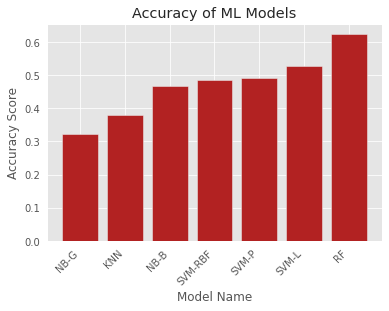

In [ ]:
plt.style.use('ggplot')
scoresDf = scoresDf.sort_values('accuracy')

plt.bar(scoresDf['model_name'], scoresDf['accuracy'], color='firebrick')
plt.xlabel("Model Name")
plt.ylabel("Accuracy Score")
plt.title("Accuracy of ML Models")
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

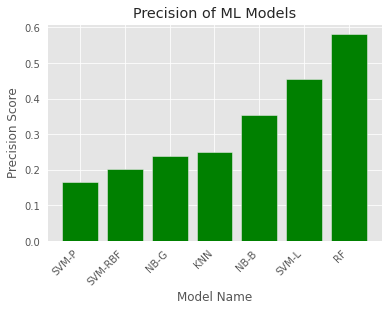

In [ ]:
plt.style.use('ggplot')
scoresDf = scoresDf.sort_values('precision')

plt.bar(scoresDf['model_name'], scoresDf['precision'], color='green')
plt.xlabel("Model Name")
plt.ylabel("Precision Score")
plt.title("Precision of ML Models")
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

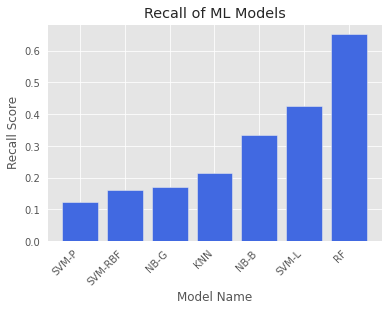

In [ ]:
plt.style.use('ggplot')
scoresDf = scoresDf.sort_values('recall')

plt.bar(scoresDf['model_name'], scoresDf['recall'], color='royalblue')
plt.xlabel("Model Name")
plt.ylabel("Recall Score")
plt.title("Recall of ML Models")
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

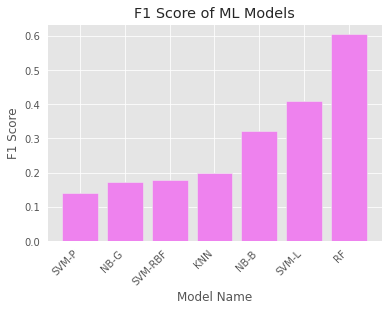

In [ ]:
plt.style.use('ggplot')
scoresDf = scoresDf.sort_values('f1_score')

plt.bar(scoresDf['model_name'], scoresDf['f1_score'], color='violet')
plt.xlabel("Model Name")
plt.ylabel("F1 Score")
plt.title("F1 Score of ML Models")
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
plt.style.use('ggplot')
scoresDf = scoresDf.sort_values('t1')
t = scoresDf['t1']*100
plt.bar(scoresDf['model_name'], t, color='orange')
plt.xlabel("Model Name")
plt.ylabel("Time (milliseconds)")
plt.title("Time Elasped for ML Models")
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()